In [1]:
###############
### IMPORTS ###
###############

#Run in Physics1 Environment

import pylab
import pandas as pd

import numpy as np

import scipy as sc
import scipy.stats as stats

import astropy
from astropy import units as u
from astropy.table import Table

from astroquery.gaia import Gaia

import galpy
import galpy.df
from galpy.potential import MWPotential2014 as pot
from galpy.potential import SpiralArmsPotential, GaussianAmplitudeWrapperPotential, evaluatePotentials, evaluateDensities
from galpy.actionAngle import actionAngleAdiabatic, actionAngleStaeckel
from galpy.util import conversion
from galpy.util import coords
from galpy.util.plot import dens2d
from galpy.potential import plotPotentials
from galpy.potential import evaluatePotentials
from galpy.potential import plotRotcurve
from galpy.potential import vcirc
from galpy.potential import lindbladR

import matplotlib
from matplotlib.pyplot import *
from matplotlib.pyplot import hist2d
from matplotlib import pyplot as pl
pl.rc('text', usetex=False)
pl.rc('font', **{'family':'DejaVu Sans','size':20})
pl.rc('axes', labelsize=16)
pl.rc('xtick',labelsize=16)
pl.rc('ytick',labelsize=16)
from matplotlib import colors as mc
from matplotlib import cm
from matplotlib.colors import LogNorm
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import pickle
infile = open("Actions_500pc.pickle","rb")
dict = pickle.load(infile)

# print(dict)

In [2]:
# dataframe with kinematics
df = pd.DataFrame(data=dict) 
# results = Table.read(dict, format="csv")
# df = results.to_pandas()
df.columns
ra_deg  = df['RA'].values #right ascension [rad] in ICRS
dec_deg = df['DEC'].values #declination [rad] in ICRS
d_kpc   = 1/df['Plx'].values  #distance from Sun [kpc]

#Velocity of stars:
pm_ra_masyr  = df['PMRA'].values #proper motion in direction of right ascension [mas/yr] in ICRS
pm_dec_masyr = df['PMDEC'].values #proper motion in direction of declination [mas/yr] in ICRS
v_los_kms    = df['RV'].values #line-of-sight velocity [km/s]

In [3]:
#Galactocentric position of the Sun:
X_GC_sun_kpc = 8.    #[kpc]
Z_GC_sun_kpc = 0.025 #[kpc] (e.g. Juric et al. 2008)

#Velocity of the Sun w.r.t. the Local Standard of Rest (e.g. Schoenrich et al. 2009):
U_LSR_kms = 11.1  # [km/s]
V_LSR_kms = 12.24 # [km/s]
W_LSR_kms = 7.25  # [km/s]

#circular velocity of the Galactic potential at the radius of the Sun:
vcirc_kms = 220. #[km/s] (e.g. Bovy 2015)

#Galactocentric velocity of the Sun:
vX_GC_sun_kms = -U_LSR_kms           # = -U              [km/s]
vY_GC_sun_kms =  V_LSR_kms+vcirc_kms # = V+v_circ(R_Sun) [km/s]
vZ_GC_sun_kms =  W_LSR_kms           # = W               [km/s]

In [4]:
#galpy scale units:
_REFR0 = 8.   #[kpc]  --> galpy length unit
_REFV0 = 220. #[km/s] --> galpy velocity unit

In [5]:
#Transformation to Galactic sky coordinates:
#_____(ra,dec) --> Galactic coordinates (l,b):_____

lb = coords.radec_to_lb(
                ra_deg,dec_deg,
                degree=True,
                epoch=None
                )
l_deg = lb[:,0]
b_deg = lb[:,1]
print("galpy ICRS:\t\t(l,b) =\t\t",l_deg,b_deg," [deg]")

#_____(pm_ra,pm_dec) --> (pm_l,pm_b)_____
pmlpmb = coords.pmrapmdec_to_pmllpmbb(
                    pm_ra_masyr,
                    pm_dec_masyr,
                    ra_deg,dec_deg,
                    degree=True,
                    epoch=None
                    )
pml_masyr = pmlpmb[:,0]
pmb_masyr = pmlpmb[:,1]
xyz = coords.lbd_to_XYZ(
                l_deg,b_deg,
                d_kpc,
                degree=True)
X_HC_kpc = xyz[:,0]
Y_HC_kpc = xyz[:,1]
Z_HC_kpc = xyz[:,2]

#_____(v_los,pm_l,pm_b) & (l,b,d) --> (vx,vy,vz)______
vxvyvz = coords.vrpmllpmbb_to_vxvyvz(
                v_los_kms,
                pml_masyr,pmb_masyr,
                l_deg,b_deg,
                d_kpc,
                XYZ=False,degree=True
                )
U_HC_kms = vxvyvz[:,0]
V_HC_kms = vxvyvz[:,1]
W_HC_kms = vxvyvz[:,2]
# use this to go to cylindrical coords used in Trick+19
#______(X,Y,Z) --> Galactic, Galactocentric cylindrical coordinates (R,phi,z)______:
Rzphi= coords.XYZ_to_galcencyl(
                X_HC_kpc, Y_HC_kpc, Z_HC_kpc, 
                Xsun=X_GC_sun_kpc,Zsun=Z_GC_sun_kpc
                )
R_kpc   = Rzphi[:,0]
phi_rad = Rzphi[:,1]
z_kpc   = Rzphi[:,2]

#______(vx,vy,vz) & (x,y,z) --> (vR,vT,vz)______
vRvTvZ = coords.vxvyvz_to_galcencyl(
                U_HC_kms, 
                V_HC_kms, 
                W_HC_kms, 
                R_kpc,
                phi_rad, 
                z_kpc,
                Xsun=X_GC_sun_kpc,Zsun=Z_GC_sun_kpc,
                vsun=[vX_GC_sun_kms,vY_GC_sun_kms,vZ_GC_sun_kms], 
                galcen=True
                )
vR_kms = vRvTvZ[:,0]
vT_kms = vRvTvZ[:,1]
vz_kms = vRvTvZ[:,2]

R   = R_kpc    / _REFR0   #Galactocentric radius
vR  = vR_kms   / _REFV0   #radial velocity
phi = phi_rad             #Galactocentric azimuth angle (not needed for actions in axisymmetric potential)
vT  = vT_kms / _REFV0     #tangential velocity
z   = z_kpc   / _REFR0    #height above plane
vz  = vz_kms  / _REFV0    #vertical velocity
aAS = actionAngleStaeckel(
        pot   = pot,        #potential
        delta = 0.45,       #focal length of confocal coordinate system
        c     = True        #use C code (for speed)
        )
jR,lz,jz = aAS(R,vR,vT,z,vz)
print("Radial   action  J_R = ", jR*_REFR0*_REFV0,"\t kpc km/s")
print("Vertical action  J_z = ", jz*_REFR0*_REFV0,"\t kpc km/s")
print("Angular momentum L_z = ", lz*_REFR0*_REFV0,"\t kpc km/s")

galpy ICRS:		(l,b) =		 [284.40325366 284.18137024 283.69737566 ... 328.30527031 328.19364708
 328.0293963 ] [-42.17353469 -42.06969755 -41.41008782 ...  11.45664917  11.49115086
  11.56669137]  [deg]
Radial   action  J_R =  [117.2897021  205.60528583   2.51065954 ...   4.47420032  61.21412752
  94.78356579] 	 kpc km/s
Vertical action  J_z =  [ 0.69221468 22.92725321  2.96929539 ...  3.49928     1.65321987
  0.57728397] 	 kpc km/s
Angular momentum L_z =  [1298.02612271 1051.26046258 1673.4896449  ... 1698.43141675 1511.42884569
 1488.41689431] 	 kpc km/s


numpy.float64

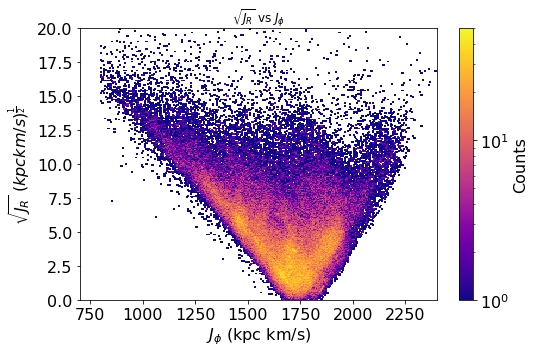

In [8]:
fig = pl.figure(figsize=(8,5))
pl.hist2d(lz*_REFR0*_REFV0, np.sqrt(jR*_REFR0*_REFV0), bins=(300,300), norm=LogNorm(), cmap='plasma', range=[[800,2500],[0,20]])
# pl.hist2d(np.isfinite(lz*_REFR0*_REFV0), np.isfinite(np.sqrt(jR*_REFR0*_REFV0)), bins=(100,100), norm=LogNorm(), cmap='plasma')
pl.title('$\sqrt{J_{R}}$ vs $J_{\phi}$')
pl.xlabel('$J_{\phi}$ (kpc km/s)')
pl.ylabel(r'$\sqrt{J_{R}}$ $(kpc km/s)^{\frac{1}{2}}$')
cbar = pl.colorbar()
cbar.ax.set_ylabel('Counts')
pl.xlim(700,2400)
pl.ylim(0,20)
pl.show

In [ ]:
###############################
### SPIRAL MODEL PARAMETERS ###
###############################

CRs = 1.            # corotation radius (put in natural units)
v_c = vcirc(mwp,R=CRs)      # v_circ at corotation radius (R in [natunits])
omegas = v_c/CRs   

In [ ]:
#########################################################
###############      Create Function       ##############
###############  to Obtain Radial Action   ##############
###############     from Jacobi Energy     ##############
###############   at Primary Resonances    ##############
#########################################################


from galpy.potential import epifreq


def getJRfromJacobienergy(m, omegas): 

#     pot = mwp
#     m = 4
#     ro = 8
#     vo = 220

    OLR = lindbladR(Pot=pot, OmegaP=omegas, m=-m, ro=ro,vo=vo) # m being negative makes this an OLR; in physical units
    ILR = lindbladR(Pot=pot, OmegaP=omegas, m=m, ro=ro,vo=vo) #lindbladR must have ro and vo in order to solve tuple problem
    CR = lindbladR(Pot=pot, OmegaP=omegas, m='corotation', ro=ro,vo=vo)

    pot_ILR = evaluatePotentials(mwp, ILR, z=0, phi=0, ro=ro,vo=vo)
    pot_OLR = evaluatePotentials(mwp, OLR, z=0, phi=0, ro=ro,vo=vo)
    pot_CR = evaluatePotentials(mwp, CR, z=0, phi=0, ro=ro,vo=vo)

#     print ('This is evaluatepotential for ILR:',pot_ILR)
#     print ('\nThis is evaluatepotential for OLR:',pot_OLR)
#     print ('\nThis is evaluatepotential for CR:',pot_CR)

    # print ('This is mwp:',mwp)
    kappa_ILR = epifreq(pot,R=ILR/ro,ro=ro,vo=vo)
#     print ('\nThis is kappa_ILR:',kappa_ILR)

    kappa_OLR = epifreq(pot,R=OLR/ro,ro=ro,vo=vo)
#     print('\nThis is kappa_OLR:',kappa_OLR)

    kappa_CR = epifreq(pot,R=CR/ro,ro=ro,vo=vo)
#     print('\nThis is kappa_CR:',kappa_CR)

    OmegaP = omegas*(vo/ro) #pattern speed at corotation
#     print ('\nThis is OmegaP:',OmegaP)

    v_c_ILR = vcirc(mwp, R = ILR/ro, ro = ro, vo = vo) #in physical units
    OmegaP_ILR = v_c_ILR/ILR

    v_c_OLR = vcirc(mwp, R = OLR/ro, ro = ro, vo = vo) #in physical units
    OmegaP_OLR = v_c_OLR/OLR

    E_c_ILR = pot_ILR + (1/2)*vcirc(mwp,R=ILR/ro,ro=ro,vo=vo)**2
    E_c_OLR = pot_OLR + (1/2)*vcirc(mwp,R=OLR/ro,ro=ro,vo=vo)**2
    E_c_CR = pot_CR + (1/2)*vcirc(mwp,R=CR/ro,ro=ro,vo=vo)**2

#     print('\nThis is KE:', vcirc(mwp,R=ILR/ro,ro=ro,vo=vo)**2)
#     print ('\nThis is circular energy for ILR',E_c_ILR)
#     print ('\nThis is circular energy for OLR',E_c_OLR)
#     print ('\nThis is circular energy for CR',E_c_CR)

    # E_J_ILR = E_c_ILR - OmegaP*ILR*vcirc(mwp,R=ILR/ro,ro=ro,vo=vo)
    # print ('\nThis is Jacobi Integral of ILR', E_J_ILR)

    # E_J_OLR = E_c_OLR - OmegaP*OLR*vcirc(mwp,R=OLR/ro,ro=ro,vo=vo)
    # print ('\nThis is Jacobi Integral of OLR', E_J_OLR)

    # E_J_CR = E_c_CR - OmegaP*CR*vcirc(mwp,R=CR/ro,ro=ro,vo=vo)
    # print ('\nThis is Jacobi Integral of CR', E_J_CR)

    ##### Find y-intercept: J_R = ((E_J(J_R=0) - E_c)/kappa) + (OmegaP/kappa)*Lz #####
    ##### This formula has the form of y = b + m*x 
    ##### (E_J(J_R=0) - E_c)/kappa = (pot +(1/2)*vcirc**2 - OmegaP*Lz - pot - (1/2)*vcirc**2)/kappa 
    #####                          = -OmegaP*Lz/kappa 
    #####                          = -OmegaP*R_g*vcirc/kappa

    y_intercept_ILR = OmegaP*ILR*vcirc(mwp,R=ILR/ro,ro=ro,vo=vo)/kappa_ILR
    y_intercept_OLR = OmegaP*OLR*vcirc(mwp,R=OLR/ro,ro=ro,vo=vo)/kappa_OLR
    y_intercept_CR = OmegaP*CR*vcirc(mwp,R=CR/ro,ro=ro,vo=vo)/kappa_CR

#     print ('\nThis is the y intercept when R = ILR', y_intercept_ILR) 
#     print ('\nThis is the y intercept when R = OLR', y_intercept_OLR) 
#     print ('\nThis is the y intercept when R = CR', y_intercept_CR) 
    ####################################################################################

    Lz = np.linspace(0,2600)

    J_R_ILR = -y_intercept_ILR + (OmegaP*Lz)/kappa_ILR
    J_R_OLR = -y_intercept_OLR + (OmegaP*Lz)/kappa_OLR
    J_R_CR = -y_intercept_CR + (OmegaP*Lz)/kappa_CR

    # plt.plot(Lz,J_R_ILR)
    # plt.plot(Lz,J_R_OLR)
    # plt.plot(Lz,J_R_CR)
    # plt.xlabel('$L_{z}$')
    # plt.ylabel('$J_{R}$')
    
    return J_R_ILR, J_R_OLR, J_R_CR

#getJRfromJacobienergy(4)[0] # This outputs J_R_ILR
# getJRfromJacobienergy(4)[1] # This outputs J_R_OLR
# getJRfromJacobienergy(4)[2] # This outputs J_R_CR

In [ ]:
#############################################################
###############         Create Full            ##############
###############     Orbital Action Graphs      ##############
###############   for All Primary Resonances   ##############
#############################################################


def getangularactiongraph(nbins, colormap, normalize, CRs, m, jphi, jphi_quiet, jr, jr_quiet, cbarlabel_deltajphi, cbarlabel_deltajr, xaxislabel, yaxislabel,vlinelabelILR,vlinelabelOLR):     
           
    ################################
    #########  Parameters  #########
    ################################
    
    normalize = normalize
    colormap = colormap
    
    ro = _REFR0
    vo = _REFV0
    
    OLR = lindbladR(Pot=pot, OmegaP=omegas, m=-m, ro=ro,vo=vo) # m being negative makes this an OLR; in physical units
    ILR = lindbladR(Pot=pot, OmegaP=omegas, m=m, ro=ro,vo=vo) #lindbladR must have ro and vo in order to solve tuple problem
    CR = lindbladR(Pot=pot, OmegaP=omegas, m='corotation', ro=ro,vo=vo) #m=2 is LR and m=4 is Ultraharmonic LR

#     Lz = np.linspace(0,2600)
    Lz = lz
    
    nbins = 201
    
    delta_jphi = jphi - jphi_quiet 
    delta_jr = jr - jr_quiet

    jphimax = jphi_quiet.max()
    jphimin = jphi_quiet.min()
    jrmin = jr_quiet.min()
    jrmax = jr_quiet.max()
    delta_jphimin = delta_jphi.min()
    delta_jphimax = delta_jphi.max()
    
    ####### This block is to make any zeros in the graphs white or blend in with background ########

    for i in range(len(jphi_f)): #was jphii0
        if (jphi_quiet[i]<jphimin or jphi_quiet[i]>jphimax or jr_quiet[i]<jrmin or jr_quiet[i]>jrmax or delta_jphi[i]<delta_jphimin or delta_jphi[i]>delta_jphimax):
            jphi[i]=float("NaN")
        is_nan = (jphi[:] != jphi[:])
        jphi = jphi[~is_nan]
        jr = jr[~is_nan]
        delta_jphi = delta_jphi[~is_nan]
        
    ####### Histogram Setups ########    

    statistic, x_edges, y_edges, binnumber = stats.binned_statistic_2d(jphi_quiet*ro*vo, jr_quiet*ro*vo, delta_jphi*ro*vo, statistic='mean', bins=nbins)
    statistic1, x_edges, y_edges, binnumber = stats.binned_statistic_2d(jphi_quiet*ro*vo, jr_quiet*ro*vo, delta_jr*ro*vo, statistic='mean', bins=nbins)

    x_width = (x_edges[1]-x_edges[0])
    x_centers = x_edges[1:]-x_width/2
    xi = x_centers

    y_width = (y_edges[1]-y_edges[0])
    y_centers = y_edges[1:]-y_width/2
    yi = y_centers

    ji = np.transpose(statistic)
    ji1 = np.transpose(statistic1)

 

    #####################################################
    ##### Plot Jr vs Jphi color coded by delta Jphi #####
    #####################################################
        
        
    fig, ax = pl.subplots()
    # ax.set_aspect(1.)
    change_j = ax.pcolormesh(xi, yi,ji, cmap = colormap, norm=normalize,shading='auto') #let's look at it in logarithmic map
    cbar = pl.colorbar(change_j,ax=ax,fraction=0.03,extend='both') #both caps it at clim, but it can go further than that limit
    cbar.set_label(cbarlabel_deltajphi, rotation = 270,labelpad=30)
    cbar.mappable.set_clim(-100,100)
    
#     pl.title(''+str(m)+' : 1')
    pl.xlabel(xaxislabel)
    pl.ylabel(yaxislabel) #units: root Jr which will change shape into V

    pl.xlim(200,2500) #comment out for auto
    pl.ylim(0,150)    #originally 0,300
    
    pl.plot(Lz,-getJRfromJacobienergy(m)[0],color='green',ls='-',label='ILR')
    pl.plot(Lz,-getJRfromJacobienergy(m)[1],color='blue',ls='-',label='OLR')
    pl.plot(Lz,-getJRfromJacobienergy(m)[2],color='red',ls='-',label='CR')
    
    pl.legend(fontsize=10)
    pl.legend(bbox_to_anchor=(1.25,1.),loc='upper left')
    pl.show()
    
    
    
    ###################################################
    ##### Plot Jr vs Jphi color coded by delta Jr #####
    ###################################################
    
    
    fig, ax = pl.subplots()
    change_j = ax.pcolormesh(xi, yi,ji1, cmap = colormap, norm=normalize,shading='auto') #let's look at it in logarithmic map
    cbar = pl.colorbar(change_j,ax=ax,fraction=0.03,extend='both') #both caps it at clim, but it can go further than that limit
    cbar.set_label(cbarlabel_deltajr, rotation = 270,labelpad=30)
    cbar.mappable.set_clim(-50,50)
    
#     pl.title(''+str(m)+' : 1')
    pl.xlabel(xaxislabel)
    pl.ylabel(yaxislabel) #units: root Jr which will change shape into V

    pl.plot(Lz,-getJRfromJacobienergy(m)[0],color='green',ls='-',label='ILR')
    pl.plot(Lz,-getJRfromJacobienergy(m)[1],color='blue',ls='-',label='OLR')
    pl.plot(Lz,-getJRfromJacobienergy(m)[2],color='red',ls='-',label='CR')
    
    pl.legend(fontsize=10)
    pl.legend(bbox_to_anchor=(1.25,1.),loc='upper left')
    
    pl.xlim(200,2500) #comment out for auto
    pl.ylim(0,150)    #originally 0,300
    
    pl.show()
    # look at Jphi and jz
    
   
    
##################################################
#####  Command to make and print the graphs  #####
##################################################
    
        
#Total    
getangularactiongraph(nbins=101, colormap='coolwarm', normalize=mc.Normalize(), CRs=1, m=4, jphi=jphi_f, jphi_quiet=jphi_o, jr=jR_f, jr_quiet=jR_o,cbarlabel_deltajphi='$\Delta\ J_{\phi_{total}}$', cbarlabel_deltajr='$\Delta\ J_{r_{total}}$', xaxislabel='$J_{\phi_{o}}$ (kpc km/s)',yaxislabel='$J_{r_{o}}$ (kpc km/s)', vlinelabelILR='ILR', vlinelabelOLR='OLR')

#Growth  
getangularactiongraph(nbins=101, colormap='coolwarm', normalize=mc.Normalize(), CRs=1, m=4, jphi=jphi_fg, jphi_quiet=jphi_o, jr=jR_fg, jr_quiet=jR_o,cbarlabel_deltajphi='$\Delta\ J_{\phi_{growth}}$', cbarlabel_deltajr='$\Delta\ J_{r_{growth}}$', xaxislabel='$J_{\phi_{o}}$ (kpc km/s)',yaxislabel='$J_{r_{o}}$ (kpc km/s)', vlinelabelILR='ILR', vlinelabelOLR='OLR')

#Decay  
getangularactiongraph(nbins=101, colormap='coolwarm', normalize=mc.Normalize(), CRs=1, m=4, jphi=jphi_f, jphi_quiet=jphi_fg, jr=jR_f, jr_quiet=jR_fg,cbarlabel_deltajphi='$\Delta\ J_{\phi_{decay}}$', cbarlabel_deltajr='$\Delta\ J_{r_{decay}}$', xaxislabel='$J_{\phi_{peak}}$ (kpc km/s)',yaxislabel='$J_{r_{peak}}$ (kpc km/s)', vlinelabelILR='ILR', vlinelabelOLR='OLR')